In [107]:
import numpy as np
import pandas as pd

In [128]:
def preprocess(df):
    df.rename(columns = {'Load [MWh]':'load', 'Time [s]':'time', 'City':'city'}, inplace = True)
    df.time = pd.to_datetime(df.time)

In [129]:
def encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)

In [130]:
def add_time_features(df, drop=True):
    # year - 2015?
    df['hour'] = df.time.dt.hour
    df['day_name'] = df.time.dt.day_name()
    df['weekday'] = df.time.dt.weekday
    df['day'] = df.time.dt.day
    df['month'] = df.time.dt.month
    df['year'] = df.time.dt.year
    df['dayofyear'] = df.time.dt.dayofyear
    
    encode(df, 'hour', 23)
    encode(df, 'day', 23)
    encode(df, 'month', 23)
    encode(df, 'dayofyear', 23)
    
    if drop:
        df.drop(columns = ['time'], inplace = True)

In [131]:
df_train = pd.read_csv('/hkfs/work/workspace/scratch/bh6321-energy_challenge/data/train.csv')

In [132]:
df_val = pd.read_csv('/hkfs/work/workspace/scratch/bh6321-energy_challenge/data/valid.csv')

In [133]:
df_train.head()

,Load [MWh],Time [s],City
0,263.365956,2015-01-01 00:00:00,bs
1,259.073621,2015-01-01 01:00:00,bs
2,246.612481,2015-01-01 02:00:00,bs
3,238.313719,2015-01-01 03:00:00,bs
4,237.114390,2015-01-01 04:00:00,bs


In [134]:
preprocess(df_train)

In [135]:
add_time_features(df_train)

In [136]:
df_train.head()

,load,city,hour,day_name,weekday,day,month,year,dayofyear,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos
0,263.365956,bs,0,Thursday,3,1,1,2015,1,0.000000,1.000000,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917
1,259.073621,bs,1,Thursday,3,1,1,2015,1,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917
2,246.612481,bs,2,Thursday,3,1,1,2015,1,0.519584,0.854419,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917
3,238.313719,bs,3,Thursday,3,1,1,2015,1,0.730836,0.682553,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917
4,237.114390,bs,4,Thursday,3,1,1,2015,1,0.887885,0.460065,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917


In [137]:
preprocess(df_val)

In [138]:
add_time_features(df_val)

In [139]:
df_val.head()

,load,city,hour,day_name,weekday,day,month,year,dayofyear,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,dayofyear_sin,dayofyear_cos
0,208.066865,bs,0,Monday,0,1,1,2018,1,0.000000,1.000000,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917
1,202.341276,bs,1,Monday,0,1,1,2018,1,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917
2,191.499046,bs,2,Monday,0,1,1,2018,1,0.519584,0.854419,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917
3,183.315389,bs,3,Monday,0,1,1,2018,1,0.730836,0.682553,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917
4,181.941545,bs,4,Monday,0,1,1,2018,1,0.887885,0.460065,0.269797,0.962917,0.269797,0.962917,0.269797,0.962917


In [140]:
df_train.to_csv('data/processed/train.csv', index=False)

In [141]:
df_val.to_csv('data/processed/valid.csv', index=False)

<AxesSubplot:>

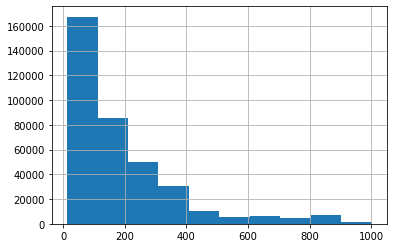

In [83]:
df_train.load.hist()

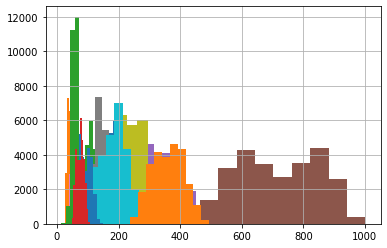

In [84]:
df_train.groupby('city')['load'].hist();

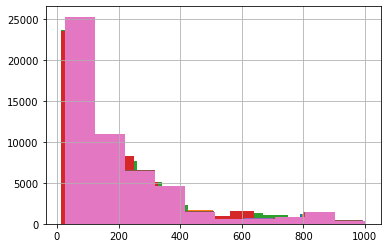

In [85]:
df_train.groupby('day_name')['load'].hist();

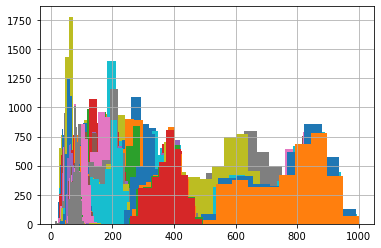

In [86]:
df_train.groupby(['city', 'day_name'])['load'].hist();

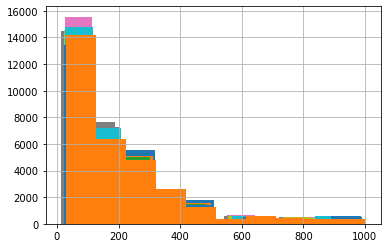

In [87]:
df_train.groupby('month')['load'].hist();

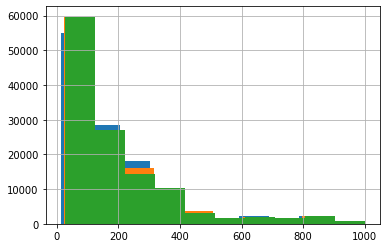

In [49]:
df_train.groupby('year')['load'].hist();

In [10]:
df_train.city.nunique()

14